# Pre-Processing

## 1.Importing the libraries

In [2]:
import pandas as pd
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor


## 2. Importing and cleaning the datasets

Note : the output.csv file is generated using the json-to-csv script with all of the json files in the same directory as the script as input


### 2.1 Traffic Data

In [4]:
#-- Traffic Data -- 
traffic_data = pd.read_csv("Datasets/Traffic Detectors/Data/2023/April/output.csv")
traffic_data['intensity'] = pd.to_numeric(traffic_data['intensity'], errors='coerce')
traffic_data['occupancy'] = pd.to_numeric(traffic_data['occupancy'], errors='coerce')
traffic_data['dateObservedFrom'] = pd.to_datetime(traffic_data['dateObservedFrom'], errors='coerce')

# Check for missing values
print(traffic_data.isnull().sum())

# Drop duplicates
traffic_data.drop_duplicates(inplace=True)
traffic_data.describe()


/tmp/ipykernel_42655/408710357.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  traffic_data['dateObservedFrom'] = pd.to_datetime(traffic_data['dateObservedFrom'], errors='coerce')


dateObservedFrom    0
dateObservedTo      0
id                  0
location            0
intensity           0
occupancy           0
dtype: int64


,intensity,occupancy
count,2787563.000,2787563.000
mean,173.615,12.649
std,235.795,21.639
min,0.000,0.000
25%,18.000,0.000
50%,90.000,3.000
75%,258.000,14.000
max,12504.000,100.000


### 2.2 Parking Lots

In [5]:
#-- Parking Lots --

# Directory where CSV files are located
csv_dir = 'Datasets/CMP_parkingLots'

# List of CSV files
csv_files = [
    'parque_cardosas_m.csv',
    'parque_casa_da_musica_pcm_m.csv',
    'parque_loule_m.csv',
    'parque_palacio_da_justica_m.csv',
    'parque_praca_lisboa_m.csv',
    'parque_ribeira_m.csv',
    'parque_trindade_m.csv'
]

# Initialize an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Iterate through each CSV file
for csv_file in csv_files:
    file_path = os.path.join(csv_dir, csv_file)

    # Read the CSV file
    df = pd.read_csv(file_path)

    if 'occupied_spaces' in df.columns:
        # Replace negative 'occupied_spaces' values with 0
        df['occupied_spaces'] = df['occupied_spaces'].apply(lambda x: max(0, x))

    # Add a column indicating the source file
    df['source_file'] = csv_file

    # Handle differences in column names
    if 'occupied_spaces' in df.columns and 'total_spaces' in df.columns:
        # Calculate 'available_spaces' by subtracting 'occupied_spaces' from 'total_spaces'


        df['available_spaces'] = df['total_spaces'] - df['occupied_spaces']
    elif 'available_spaces' not in df.columns and 'occupied_spaces' in df.columns:
        # If 'available_spaces' column is not present, and 'occupied_spaces' is present
        df['available_spaces'] = df['total_spaces'] - df['occupied_spaces']
    elif 'occupied_spaces' not in df.columns and 'available_spaces' in df.columns:
        # If 'occupied_spaces' column is not present, and 'available_spaces' is present
        pass  # No need to modify the DataFrame
    else:
        # Handle other cases as needed
        raise ValueError(f"Unsupported column structure in file: {csv_file}")
    
    if 'occupied_spaces' in df.columns:
        # Drop 'occupied_spaces' column
        df.drop('occupied_spaces', axis=1, inplace=True)

    # Concatenate the data to the combined DataFrame
    combined_data = pd.concat([combined_data, df], ignore_index=True)

combined_data.to_csv('Datasets/CMP_parkingLots/output.csv', index=False)


# Display the combined DataFrame
combined_data.head()
combined_data.describe()

,total_spaces,available_spaces
count,860332.000,860332.000
mean,256.957,214.871
std,156.372,109.353
min,0.000,-22.000
25%,250.000,189.000
50%,250.000,244.000
75%,250.000,250.000
max,893.000,798.000


### 2.3 Train Data


In [6]:
# Assuming 'train_data' is your DataFrame
train_data = pd.read_excel("Datasets/Tip Validations/2023/TIP_Validations/Porto Digital Ferrov 2023/202304.xlsx")

# Convert 'Ano', 'Mês', 'Dia', and 'Hora' columns to datetime separately
train_data['Date'] = pd.to_datetime(train_data[['Ano', 'Mês', 'Dia']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')
train_data['Time'] = pd.to_datetime(train_data['Hora'].astype(str), format='%H').dt.time

# Combine 'Date' and 'Time' columns into a single timestamp column
train_data['Timestamp'] = pd.to_datetime(train_data['Date'].astype(str) + ' ' + train_data['Time'].astype(str))

# Drop unnecessary columns 'Ano', 'Mês', 'Dia', 'Hora', 'Date', and 'Time'
train_data = train_data.drop(['Ano', 'Mês', 'Dia', 'Hora', 'Date', 'Time'], axis=1)

# Save the DataFrame to a CSV file
train_data.to_csv('output.csv', index=False)

# Display the updated DataFrame
train_data.head()

,Operador,Est/Op,Zona,Validações,Timestamp
0,Metro do Porto,Fonte do Cuco - Linha T,MAI1,31,2023-04-04 17:00:00
1,CP-Porto,CP-Porto / Devesas,VNG1,23,2023-04-07 12:00:00
2,Metro do Porto,Nasoni,PRT3,4,2023-04-08 20:00:00
3,Metro do Porto,Lapa,PRT1,2,2023-04-25 01:00:00
4,Metro do Porto,Árvore,VCD3,6,2023-04-20 15:00:00


### 2.4 Traffic merging with Metro Data


In [19]:

# Read the CSV files into pandas DataFrames
df1 = pd.read_csv('output.csv', parse_dates=['Timestamp'])
df2 = pd.read_csv('output-traffic.csv', parse_dates=['dateObservedFrom'])
# Convert 'dateObservedFrom' column to datetime format and set the time zone
df2['dateObservedFrom'] = pd.to_datetime(df2['dateObservedFrom']).dt.tz_convert('UTC')

# Set the time zone for 'Timestamp' column in df1
df1['Timestamp'] = df1['Timestamp'].dt.tz_localize('UTC')

# Merge DataFrames on the common timestamp column
merged_df = pd.merge(df1, df2, left_on='Timestamp', right_on='dateObservedFrom', how='inner')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_file.csv', index=False)



In [24]:
merged_df.head()

,Operador,Est/Op,Zona,Validações,Timestamp,dateObservedFrom,dateObservedTo,id,location,intensity,occupancy
0,Metro do Porto,Fonte do Cuco - Linha T,MAI1,31,2023-04-04 17:00:00+00:00,2023-04-04 17:00:00+00:00,2023-04-04T18:10:00+01:00,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,"{'coordinates': [41.162725, -8.611152]}",378,65
1,Metro do Porto,Fonte do Cuco - Linha T,MAI1,31,2023-04-04 17:00:00+00:00,2023-04-04 17:00:00+00:00,2023-04-04T18:10:00+01:00,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,"{'coordinates': [41.162725, -8.611152]}",498,51
2,Metro do Porto,Fonte do Cuco - Linha T,MAI1,31,2023-04-04 17:00:00+00:00,2023-04-04 17:00:00+00:00,2023-04-04T18:10:00+01:00,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,"{'coordinates': [41.162725, -8.611152]}",120,33
3,Metro do Porto,Fonte do Cuco - Linha T,MAI1,31,2023-04-04 17:00:00+00:00,2023-04-04 17:00:00+00:00,2023-04-04T18:10:00+01:00,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,"{'coordinates': [41.162725, -8.611152]}",492,49
4,Metro do Porto,Fonte do Cuco - Linha T,MAI1,31,2023-04-04 17:00:00+00:00,2023-04-04 17:00:00+00:00,2023-04-04T18:10:00+01:00,urn:ngsi-ld:TrafficFlowObserved:porto:traffic:...,"{'coordinates': [41.162725, -8.611152]}",246,44


## 2.5 Air Quality Data



In [10]:
air_quality = pd.read_csv('Datasets/Environmental IoT Monitar/air_quality_data_monitar_processed.csv')
air_quality.describe()
air_quality.head()

,name,timestamp,co,no2,o3,pm10,pm2.5,date_observed,time_observed
0,ManutencaoPorto - SmartAirSense - Parque da Ci...,2022-01-01 00:00:00,207.000,26.000,50.000,3.000,0.000,2022-01-01,00:00:00
1,ManutencaoPorto - SmartAirSense - Parque da Ci...,2022-01-01 00:05:00,NaN,NaN,NaN,4.000,0.700,2022-01-01,00:05:00
2,ManutencaoPorto - SmartAirSense - Parque da Ci...,2022-01-01 00:10:00,NaN,NaN,NaN,4.000,1.000,2022-01-01,00:10:00
3,ManutencaoPorto - SmartAirSense - Parque da Ci...,2022-01-01 00:15:00,210.000,26.000,50.000,4.000,0.900,2022-01-01,00:15:00
4,ManutencaoPorto - SmartAirSense - Parque da Ci...,2022-01-01 00:20:00,NaN,NaN,NaN,4.000,1.000,2022-01-01,00:20:00


#### 2.5.1 Air Quality Data Pre-Processing



In [7]:
unique_names = air_quality['name'].unique()

print(unique_names)

['ManutencaoPorto - SmartAirSense - Parque da Cidade / Circunvalacao'
 'OFF - MANUTENCAO - Porto - SmartAirSense - Parque da Cidade / Circunvalacao'
 'Porto - SmartAirSense - Arca dAgua'
 'Porto - SmartAirSense - Av. da Boavista / Av. do Parque'
 'Porto - SmartAirSense -Fernao de Magalhaes / Monte Aventino']


## 3. Visualizing the data

### 3.1 Traffic Data Over Time (month)

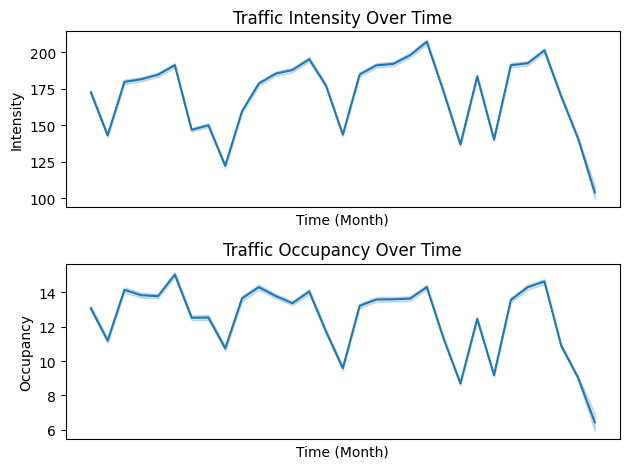

In [73]:
# Convert date columns to datetime objects
traffic_data['dateObservedFrom'] = pd.to_datetime(traffic_data['dateObservedFrom'], errors='coerce')

# Set 'dateObservedFrom' to midnight
traffic_data['dateObservedFrom'] = traffic_data['dateObservedFrom'].dt.normalize()

# Create a subplot with 2 rows and 1 column
plt.subplot(2, 1, 1)

# Line plot for 'intensity' over time
sb.lineplot(x='dateObservedFrom', y='intensity', data=traffic_data)
plt.title('Traffic Intensity Over Time')
plt.xlabel('Time (Month)')
plt.ylabel('Intensity')
plt.xticks([])

# Create a subplot with 2 rows and 1 column, and set the current subplot to the second one
plt.subplot(2, 1, 2)

# Line plot for 'occupancy' over time
sb.lineplot(x='dateObservedFrom', y='occupancy', data=traffic_data)
plt.title('Traffic Occupancy Over Time')
plt.xlabel('Time (Month)')
plt.ylabel('Occupancy')
plt.xticks([])

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()


### 3.2 Parking Avaliability Over Time

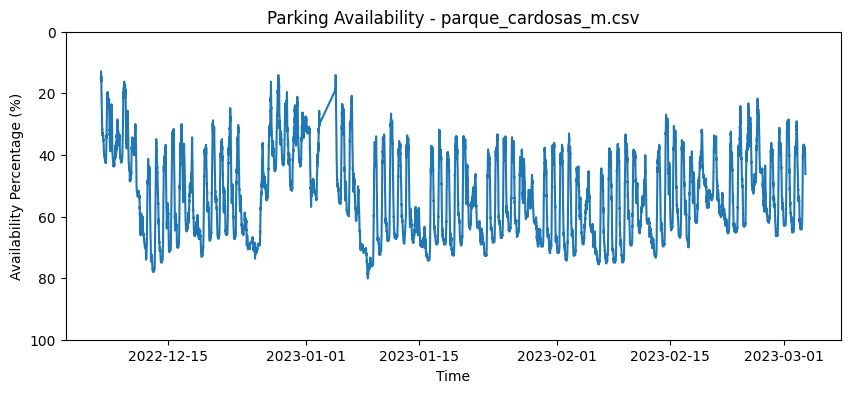

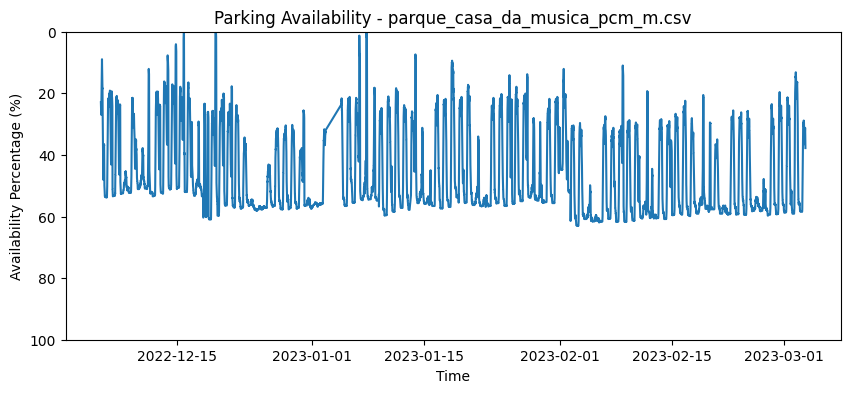

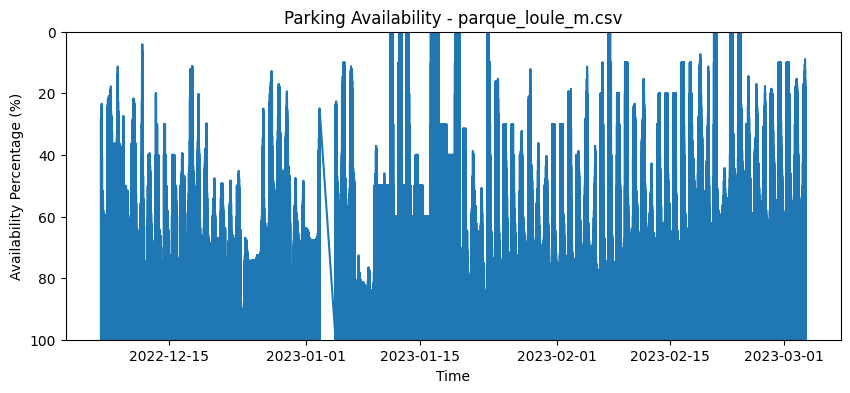

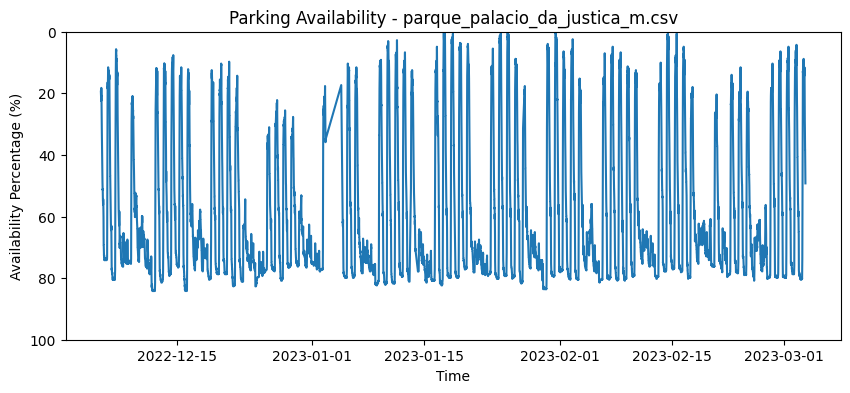

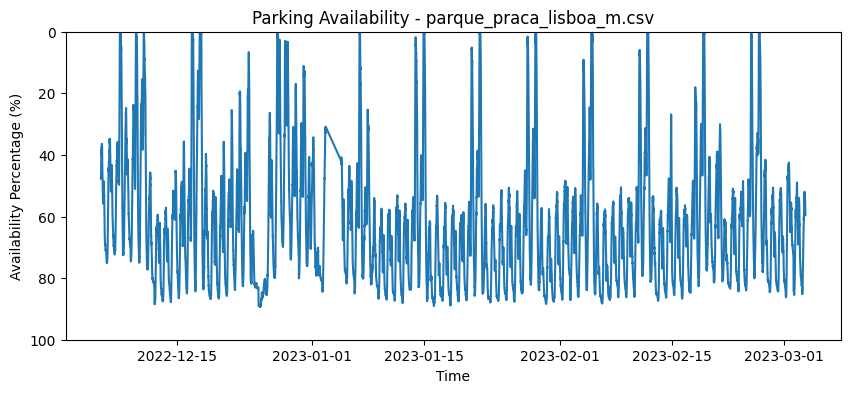

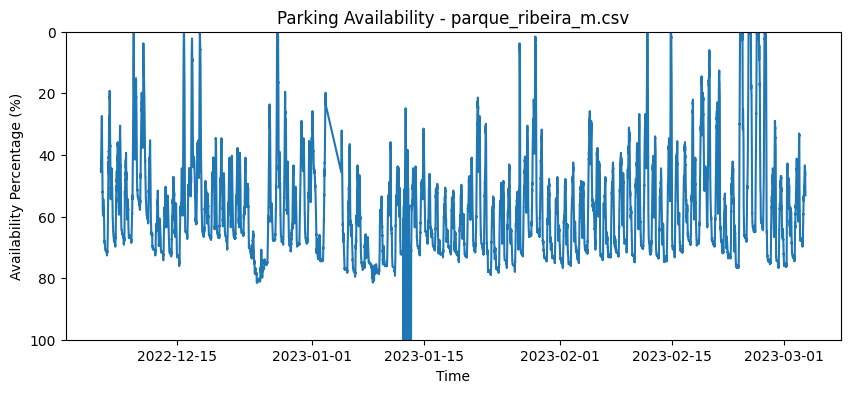

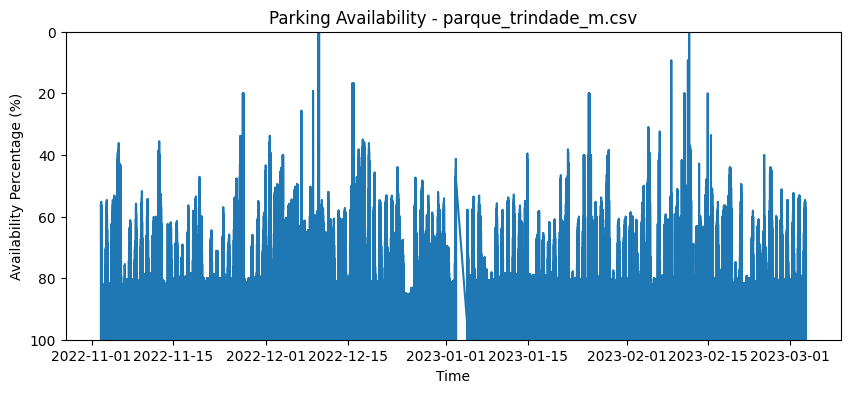

In [34]:
# Read the CSV file
df = pd.read_csv('Datasets/CMP_parkingLots/output.csv', parse_dates=['updated_at'])


# Convert 'updated_at' to datetime and set it as the index
df['updated_at'] = pd.to_datetime(df['updated_at'])
df.set_index('updated_at', inplace=True)

# Calculate availability percentage
df['availability_percentage'] = (df['available_spaces'] / df['total_spaces']) * 100

# Get unique park names
park_names = df['source_file'].unique()

# Plotting subplots
for idx, park in enumerate(park_names):
    plt.figure(figsize=(10, 4))
    
    park_data = df[df['source_file'] == park]
    plt.plot(park_data.index, park_data['availability_percentage'])
    plt.title(f'Parking Availability - {park}')
    plt.xlabel('Time')
    plt.ylabel('Availability Percentage (%)')
    plt.ylim(0, 100)  # Set the y-axis limit to 0 to 100
    plt.gca().invert_yaxis()  # Reverse the Y-axis
    plt.show()

### 3.3 Air Quality Over Time



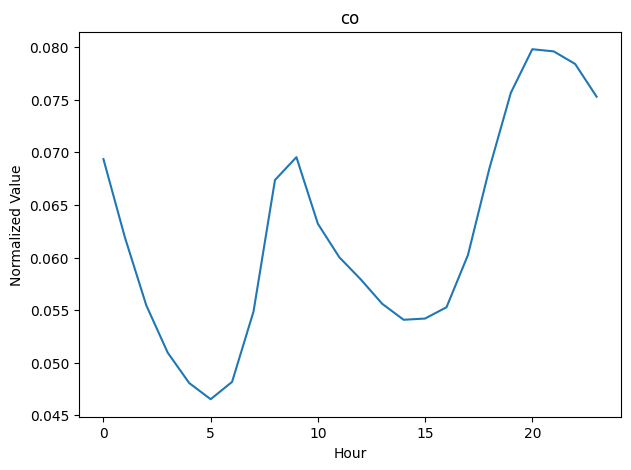

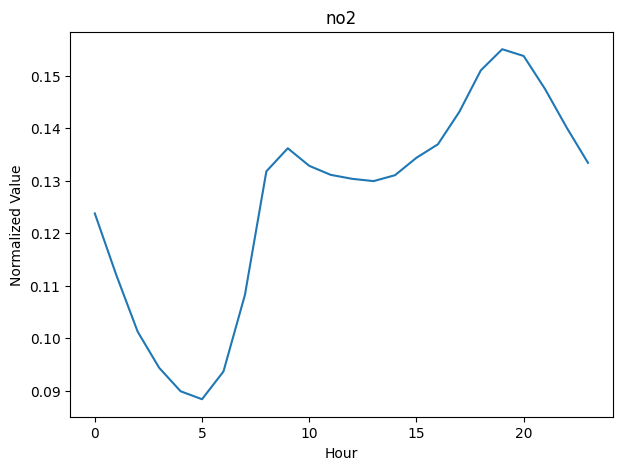

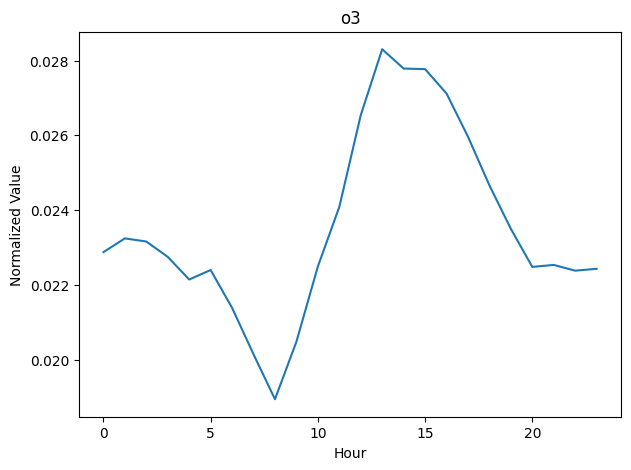

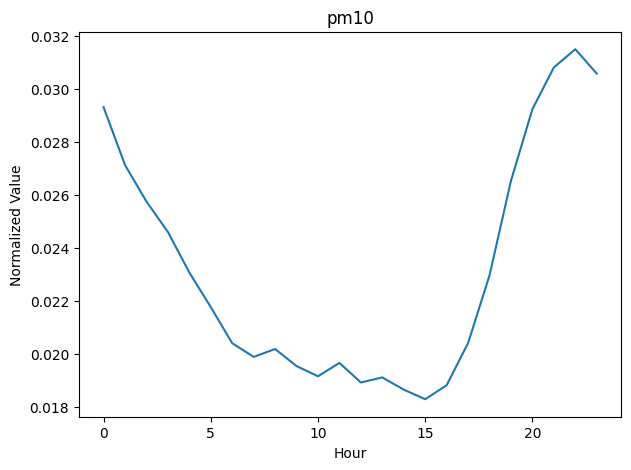

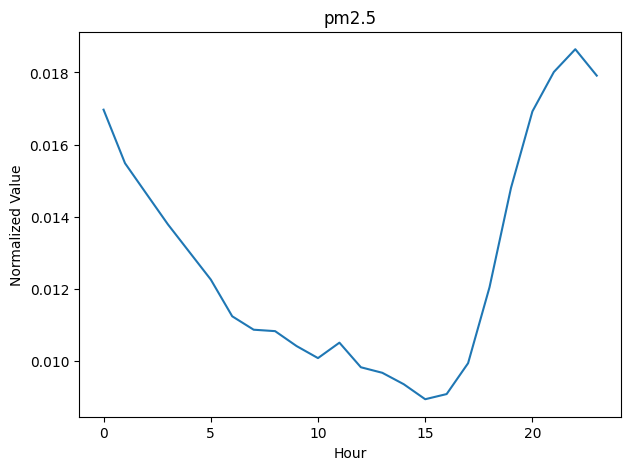

In [27]:
# Convert 'timestamp' column to datetime type
air_quality['timestamp'] = pd.to_datetime(air_quality['timestamp'])

# Convert other relevant columns to numeric type
numeric_columns = ['co', 'no2', 'o3', 'pm10', 'pm2.5']
air_quality[numeric_columns] = air_quality[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Extract hour from timestamp
air_quality['hour'] = air_quality['timestamp'].dt.hour

# Normalize each parameter and plot on a separate subplot without grouping
parameters = ['co', 'no2', 'o3', 'pm10', 'pm2.5']
for i, parameter in enumerate(parameters):
    # Set up the subplot for each parameter
    fig, ax = plt.subplots(figsize=(7, 5))
    
    normalized_values = air_quality[parameter] / air_quality[parameter].max()
    
    # Create a DataFrame with 'hour' and the normalized values
    df_normalized = pd.DataFrame({'hour': air_quality['hour'], 'normalized_value': normalized_values})
    
    sb.lineplot(data=df_normalized, x='hour', y='normalized_value', ax=ax, errorbar=None)
    ax.set_title(parameter)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Normalized Value')

    # Show the current plot
    plt.show()

# 4. Modelling

## 4.1 Metro and Parking Correlation

In [9]:
# Load the first CSV file
df1 = pd.read_csv('output.csv', parse_dates=['Timestamp'])

# Load the second CSV file
df2 = pd.read_csv('Datasets/CMP_parkingLots/output.csv', parse_dates=['updated_at'])

# Mapping between "Est/Op" in df1 and "source_file" in df2
mapping = {
    "Trindade": "parque_trindade_m.csv",
    "Casa da Música": "parque_casa_da_musica_pcm_m.csv"
}

# Filter rows in df2 based on the mapping
df2_filtered = df2[df2['source_file'].isin(mapping.values())]

# Normalize the second CSV by hour
df2_filtered['hour'] = df2_filtered['updated_at'].dt.floor('H')

# Group by hour and calculate the mean for the relevant columns
df2_normalized = df2_filtered.groupby(['hour', 'source_file']).agg({'total_spaces': 'mean', 'available_spaces': 'mean'}).reset_index()

# Merge the two dataframes based on the timestamp and source_file
merged_df = pd.merge(df1, df2_normalized, left_on=['Timestamp', 'Est/Op'], right_on=['hour', 'source_file'], how='inner')

# Drop the redundant columns
merged_df.drop(['hour', 'source_file'], axis=1, inplace=True)


/tmp/ipykernel_39749/453607108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_filtered['hour'] = df2_filtered['updated_at'].dt.floor('H')


## 4.2 Traffic and Metro Correlation

Mean Squared Error: 478.5538600279795
R-squared: 0.0013828209761382881


/home/eduardo-mdc/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


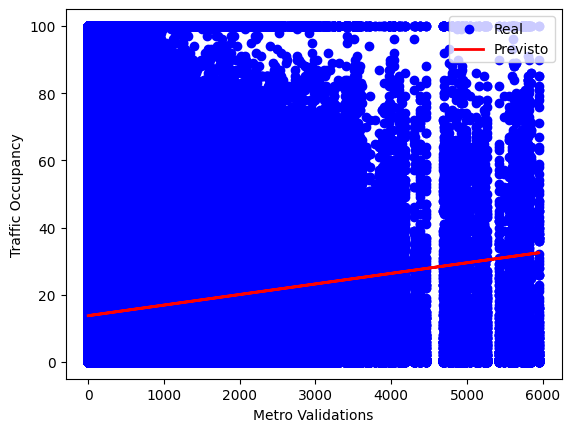

In [2]:
df = pd.read_csv('merged_file.csv')

# Suponha que 'subway_occupancy' seja a feature e 'traffic_congestion' seja a variável alvo
X = df[['Validações']]
y = df['intesity']

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie um modelo de regressão linear
regression_model = LinearRegression()

# Treine o modelo
regression_model.fit(X_train, y_train)

# Faça previsões no conjunto de teste
y_pred = regression_model.predict(X_test)

# Avalie o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plote os valores previstos versus reais
plt.scatter(X_test, y_test, color='blue', label='Real')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Previsto')
plt.xlabel('Metro Validations')
plt.ylabel('Traffic intensity')
plt.legend()
plt.show()

Mean Squared Error: 5.847913274175465e+22
R-squared: -1.0175677931903222e+18


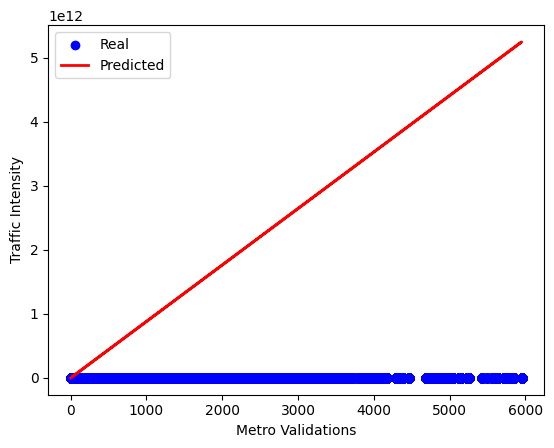

In [3]:
# Load your dataset
df = pd.read_csv('merged_file.csv')

# Assume 'Validações' as the feature and 'intensity' as the target variable
X = df[['Validações']]
y = df['intensity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a SGDRegressor model
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)

# Train the model
sgd_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = sgd_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot predicted values versus actual values
plt.scatter(X_test, y_test, color='blue', label='Real')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Metro Validations')
plt.ylabel('Traffic Intensity')
plt.legend()
plt.show()